In [1]:
import os
import datetime
from zoneinfo import ZoneInfo
import pandas as pd
import numpy as np
import ffmpeg
import PIL
from PIL import Image
from PIL import ImageOps
# from PIL import Resampling
from matplotlib import cm

In [2]:
camera_image_width, camera_image_height = 80, 60
camera_image_rescale = 1.5

mat_image_width, mat_image_height = 27, 64
camera_min_value, camera_max_value = 7886.0, 8171.0

In [3]:
centre_camera = Image.open('centre1_camera.png')
centre_mat = Image.open('centre1_mat.png')

corner1_camera = Image.open('corner1_camera.png')
corner1_mat = Image.open('corner1_mat.png')

corner2_camera = Image.open('corner2_camera.png')
corner2_mat = Image.open('corner2_mat.png')

corner3_camera = Image.open('corner3_camera.png')
corner3_mat = Image.open('corner3_mat.png')

corner4_camera = Image.open('corner4_camera.png')
corner4_mat = Image.open('corner4_mat.png')

centre_mat.mode

'L'

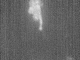

In [91]:
centre_camera

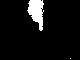

In [92]:
mask = centre_camera.point(lambda p: 255 if p > 130 else 0)
mask

In [93]:
acc = centre_camera.convert('RGBA')
acc.putalpha(mask)

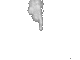

In [94]:
acc

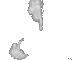

In [95]:
c = corner1_camera.convert('RGBA')
mask = corner1_camera.point(lambda p: 255 if p > 130 else 0)
c.putalpha(mask)
acc.alpha_composite(c)
acc

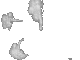

In [96]:
c = corner2_camera.convert('RGBA')
mask = corner2_camera.point(lambda p: 255 if p > 130 else 0)
c.putalpha(mask)
acc.alpha_composite(c)
acc

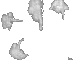

In [97]:
c = corner3_camera.convert('RGBA')
mask = corner3_camera.point(lambda p: 255 if p > 130 else 0)
c.putalpha(mask)
acc.alpha_composite(c)
acc

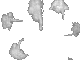

In [98]:
c = corner4_camera.convert('RGBA')
mask = corner4_camera.point(lambda p: 255 if p > 130 else 0)
c.putalpha(mask)
acc.alpha_composite(c)
acc

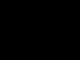

In [99]:
bg = Image.new(mode='RGBA', size=(acc.width, acc.height), color='black')
bg

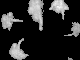

In [100]:
bg.alpha_composite(acc)
bg

In [82]:
bg.save('camera_all_points.png')

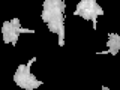

In [246]:
camera_rescale_factor = 1.50
camera_rescaled = bg.resize((int(bg.width * camera_rescale_factor), int(bg.height * camera_rescale_factor)))
camera_rescaled

In [247]:
mat_corners = Image.new(mode='RGBA', size=(27, 64), color='#0000')
mat_corners.putpixel((0,  0),  (255, 0, 0, 255))
mat_corners.putpixel((26, 0),  (255, 0, 0, 255))
mat_corners.putpixel((0,  63), (255, 0, 0, 255))
mat_corners.putpixel((26, 63), (255, 0, 0, 255))
# mat_corners = mat_corners.resize((27*4, 64*4))
mat_corners

In [248]:
mat_corners.save('mat_corners.png')

In [249]:
mat_corners.width, mat_corners.height

(27, 64)

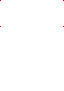

In [250]:
mc = Image.new(mode='RGBA', size=(mat_corners.width + mat_corners.height, mat_corners.width + mat_corners.height), color='#0000')
# mc.paste(mat_corners)
mat_corners_flipped= ImageOps.mirror(mat_corners)
mc.alpha_composite(mat_corners_flipped)
mc = mc.rotate(90, center=(27, 0), resample=Image.Resampling.NEAREST, fillcolor=(0, 0, 0, 0))
mc = mc.crop((mat_corners.width, 0, mat_corners.width + mat_corners.height, mat_corners.width + mat_corners.height))
# mc = ImageOps.flip(mc)
# mc.width, mc.height
mc

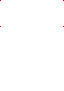

In [251]:
mc

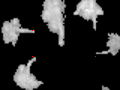

In [252]:
camera_rescaled.alpha_composite(mc, dest=(32, 30)) 
camera_rescaled

In [254]:
camera_rescaled.convert('RGB').save('camera_rescaled.png')

In [4]:
camera_path = os.path.join('data', 'camera_data') # Infra Red camera data'
mat_path = os.path.join('data', 'mat_data') # ..\Pressure Mat Data'

# centre_camera_path = os.path.join(camera_path, 'tests', 'subject1', 'Centre 1')
# centre_mat_path = os.path.join(mat_path, 'tests', 'subject1', 'Centre 1')

In [503]:
centre_camera_path = os.path.join(camera_path, 'tests', 'subject1', 'adl004')
centre_mat_path = os.path.join(mat_path, 'tests', 'subject1', 'adl004')

mat_csv_file = 'test4.csv'

outfile_name = 'adl004_mixed'

# camera_frame_number = 2
# mat_frame_number = 700

In [503]:
centre_camera_path = os.path.join(camera_path, 'tests', 'subject1', 'adl004')
centre_mat_path = os.path.join(mat_path, 'tests', 'subject1', 'adl004')

mat_csv_file = 'test4.csv'

outfile_name = 'adl004_mixed'

# camera_frame_number = 2
# mat_frame_number = 700

In [13]:
centre_camera_path = os.path.join(camera_path, 'Lyne', 'Falls IR', 'LIRAFALL29')
centre_mat_path = os.path.join(mat_path, 'Lyne', 'Falls Mat', 'LMATFALL29')

mat_csv_file = '29L.csv'

outfile_name = 'lyne_fall_29_mixed'

# camera_frame_number = 2
# mat_frame_number = 700

In [5]:
def camera_date_reader(d):
    try:
        return datetime.datetime.strptime(d, 'frame_%Y-%m-%dT%H_%M_%S.%f.csv')
    except ValueError:
        return datetime.datetime.strptime(d, 'frame_%Y-%m-%dT%H_%M_%S.csv')

In [6]:
def mat_date_reader(d):
    try:
        return datetime.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S.%f%z')
    except ValueError:
        return datetime.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S%z')

In [7]:
def vidwrite_camera(fn, images, framerate=8, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width = images.shape
    process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='gray', s=f'{width}x{height}')
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate,
                    vf="drawtext=fontfile=Arial.ttf: text=%{n}: x=0: y=h-(2*lh): fontcolor=white: box=1: boxcolor=0x00000099"
                   )
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in images:
        process.stdin.write(
            (frame * 255)
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [8]:
def vidwrite_mat(fn, images, framerate=30, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width = images.shape
    width += 1
    process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s=f'{width}x{height}')
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate,
                    vf="drawtext=fontfile=Arial.ttf: text=%{n}: x=0: y=5: fontcolor=white: box=1: boxcolor=0x00000099"
                   )
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in images:
        mod_frame = np.hstack((frame, np.zeros((64, 1), dtype=frame.dtype)))
        process.stdin.write(
            (cm.hot(mod_frame) * 255)[:, : , :-1]
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [9]:
# def vidwrite(fn, images, framerate=8, vcodec='libx264'):
#     if not isinstance(images, np.ndarray):
#         images = np.asarray(images)
#     n,height,width,channels = images.shape
#     process = (
#         ffmpeg
#             .input('pipe:', format='rawvideo', pix_fmt='rgb24', s=f'{width}x{height}')
#             .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
#             .overwrite_output()
#             .run_async(pipe_stdin=True)
#     )
#     for frame in images:
#         process.stdin.write(
#             frame
#                 .astype(np.uint8)
#                 .tobytes()
#         )
#     process.stdin.close()
#     process.wait()

In [10]:
bst_tz = datetime.timezone(datetime.timedelta(hours=1), name='BST')

In [948]:
test_dt = datetime.datetime.strptime('frame_2024-05-17T09_33_45.713423.csv', 'frame_%Y-%m-%dT%H_%M_%S.%f.csv')
test_dt

datetime.datetime(2024, 5, 17, 9, 33, 45, 713423)

In [949]:
# test_dt.replace(tzinfo='UTC+01:00')

In [950]:
test_dt.replace(tzinfo=ZoneInfo('Europe/London'))

datetime.datetime(2024, 5, 17, 9, 33, 45, 713423, tzinfo=zoneinfo.ZoneInfo(key='Europe/London'))

In [951]:
test_dt.replace(tzinfo=bst_tz)

datetime.datetime(2024, 5, 17, 9, 33, 45, 713423, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600), 'BST'))

In [14]:
camera_files = {}
for f in os.listdir(centre_camera_path):
    fp = os.path.join(centre_camera_path, f)
    if os.path.isfile(fp) and 'ContDrc' not in f:
        tm = camera_date_reader(f).replace(tzinfo=ZoneInfo('Europe/London'))
        camera_files[tm] = fp
        # print(f, tm)
camera_files = {t: camera_files[t] for t in sorted(camera_files)}
camera_files

{datetime.datetime(2024, 7, 29, 10, 40, 41, 162660, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')): 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.162660.csv',
 datetime.datetime(2024, 7, 29, 10, 40, 41, 295992, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')): 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.295992.csv',
 datetime.datetime(2024, 7, 29, 10, 40, 41, 426679, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')): 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.426679.csv',
 datetime.datetime(2024, 7, 29, 10, 40, 41, 565049, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')): 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.565049.csv',
 datetime.datetime(2024, 7, 29, 10, 40, 41, 713457, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')): 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.713457.csv',
 datetime.datetime(2024, 7, 29, 10, 40, 41, 847995, tzinfo=zoneinfo.ZoneInfo(key='Europe/L

In [15]:
time_sorted_filenames = [camera_files[t] for t in sorted(camera_files)]
time_sorted_filenames

['data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.162660.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.295992.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.426679.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.565049.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.713457.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_41.847995.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_42.013529.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_42.141981.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_42.270919.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_42.434021.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_42.560123.csv',
 'data/camera_data/Lyne/Falls IR/LIRAFALL29/frame_2024-07-29T10_40_42.706634.csv',
 'da

In [16]:
tfile = time_sorted_filenames[0]

In [17]:
ctimes = [t for t in camera_files]
diffs = [b - a for a, b in zip(ctimes, ctimes[1:])]
diffs

[datetime.timedelta(microseconds=133332),
 datetime.timedelta(microseconds=130687),
 datetime.timedelta(microseconds=138370),
 datetime.timedelta(microseconds=148408),
 datetime.timedelta(microseconds=134538),
 datetime.timedelta(microseconds=165534),
 datetime.timedelta(microseconds=128452),
 datetime.timedelta(microseconds=128938),
 datetime.timedelta(microseconds=163102),
 datetime.timedelta(microseconds=126102),
 datetime.timedelta(microseconds=146511),
 datetime.timedelta(microseconds=146542),
 datetime.timedelta(microseconds=114673),
 datetime.timedelta(microseconds=157924),
 datetime.timedelta(microseconds=179216),
 datetime.timedelta(microseconds=80894),
 datetime.timedelta(microseconds=147477),
 datetime.timedelta(microseconds=171427),
 datetime.timedelta(microseconds=128333),
 datetime.timedelta(microseconds=140792),
 datetime.timedelta(microseconds=135154),
 datetime.timedelta(microseconds=153629),
 datetime.timedelta(microseconds=177964),
 datetime.timedelta(microseconds=11

In [18]:
len(diffs), len(diffs[5:-5])

(42, 32)

In [19]:
sum(diffs[5:-5], start=datetime.timedelta(0)) / len(diffs[5:-5])

datetime.timedelta(microseconds=141068)

In [20]:
camera_frames = []
for f in time_sorted_filenames:
    arr = np.loadtxt(f, delimiter=',', usecols=list(range(80)), max_rows=60).reshape((1, 60, 80))
    camera_frames.append(arr)
camera_frames = np.vstack(camera_frames)
camera_frames.shape

(43, 60, 80)

In [21]:
cmin, cmax = np.min(camera_frames), np.max(camera_frames)
camera_frames = (camera_frames - cmin) / (cmax - cmin)
camera_frames

array([[[0.2166065 , 0.0866426 , 0.20938628, ..., 0.21299639,
         0.23826715, 0.10108303],
        [0.18050542, 0.16967509, 0.22382671, ..., 0.27075812,
         0.16245487, 0.20938628],
        [0.12635379, 0.15884477, 0.20577617, ..., 0.24909747,
         0.1732852 , 0.23465704],
        ...,
        [0.32490975, 0.32129964, 0.25270758, ..., 0.41516245,
         0.37184116, 0.31407942],
        [0.31046931, 0.37184116, 0.29963899, ..., 0.44043321,
         0.41155235, 0.28158845],
        [0.32851986, 0.23826715, 0.27075812, ..., 0.50902527,
         0.44404332, 0.44043321]],

       [[0.17689531, 0.09025271, 0.15523466, ..., 0.22743682,
         0.25631769, 0.12635379],
        [0.2166065 , 0.1299639 , 0.23104693, ..., 0.2166065 ,
         0.16967509, 0.26714801],
        [0.16245487, 0.14079422, 0.19855596, ..., 0.21299639,
         0.1732852 , 0.23465704],
        ...,
        [0.29241877, 0.31407942, 0.32490975, ..., 0.36823105,
         0.37545126, 0.31768953],
        [0.2

In [22]:
tframe = pd.read_csv(tfile, header=None, skipfooter=1, engine='python').drop(80, axis='columns')
tframe.shape

(60, 80)

In [23]:
tframe.loc[0]

0     8047
1     8011
2     8045
3     8027
4     8043
      ... 
75    8029
76    8047
77    8046
78    8053
79    8015
Name: 0, Length: 80, dtype: int64

In [24]:
mframe = pd.read_csv(os.path.join(centre_mat_path,mat_csv_file), 
                     converters={'Timestamp': mat_date_reader},
                    index_col='Frame')
mframe.dtypes

Timestamp           datetime64[ns, UTC+01:00]
Range Min (mmHg)                        int64
Range Max (mmHg)                        int64
0                                       int64
1                                       int64
                              ...            
1723                                    int64
1724                                    int64
1725                                    int64
1726                                    int64
1727                                    int64
Length: 1731, dtype: object

In [25]:
mframe

,Timestamp,Range Min (mmHg),Range Max (mmHg),0,1,2,3,4,5,6,...,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727
Frame,,,,,,,,,,,,,,,,,,,,,
1,2024-07-29 10:40:38.467000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2024-07-29 10:40:38.499000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2024-07-29 10:40:38.531000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2024-07-29 10:40:38.564000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2024-07-29 10:40:38.597000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2024-07-29 10:40:49.848000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353,2024-07-29 10:40:49.880000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354,2024-07-29 10:40:49.912000+01:00,0,104,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
len(time_sorted_filenames)

43

In [27]:
# mframe.loc[1000]['Timestamp']

In [518]:
# [t.replace(tzinfo=ZoneInfo('Europe/London')) <= mframe.loc[1000]['Timestamp'] for t in camera_files]

In [28]:
mat_times = [t.to_pydatetime() for t in mframe['Timestamp']]
mat_times

[datetime.datetime(2024, 7, 29, 10, 40, 38, 467000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 499000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 531000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 564000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 597000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 629000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 662000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 695000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 38, 728000, tzinfo=datetime.timezone(datetime.timedelta(

In [29]:
camera_times = list(sorted(camera_files.keys()))
camera_times

[datetime.datetime(2024, 7, 29, 10, 40, 41, 162660, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 41, 295992, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 41, 426679, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 41, 565049, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 41, 713457, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 41, 847995, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 42, 13529, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 42, 141981, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 42, 270919, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 datetime.datetime(2024, 7, 29, 10, 40, 42, 434021, tzinfo=zoneinfo.ZoneInfo(key='Europe/London')),
 

In [30]:
start_time = min(mat_times[0], camera_times[0])
end_time = max(mat_times[-1], camera_times[-1])
start_time, end_time

(datetime.datetime(2024, 7, 29, 10, 40, 38, 467000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2024, 7, 29, 10, 40, 49, 976000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))))

In [31]:
datetime.timedelta(seconds=(1.0 / 30))

datetime.timedelta(microseconds=33333)

In [32]:
frame_delta = datetime.timedelta(seconds=(1.0 / 30))
frame_time = start_time
frame_sources = {}

current_mat_time = None
current_camera_time = None

while frame_time < end_time:
    while mat_times and mat_times[0] < frame_time:
        current_mat_time = mat_times[0]
        mat_times = mat_times[1:]
    while camera_times and camera_times[0] < frame_time:
        current_camera_time = camera_times[0]
        camera_times = camera_times[1:]
    if not mat_times: current_mat_time = None
    if not camera_times: current_camera_time = None
    frame_sources[frame_time] = {'mat_time': current_mat_time, 'camera_time': current_camera_time}
    frame_time += frame_delta

frame_sources

{datetime.datetime(2024, 7, 29, 10, 40, 38, 467000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))): {'mat_time': None,
  'camera_time': None},
 datetime.datetime(2024, 7, 29, 10, 40, 38, 500333, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))): {'mat_time': datetime.datetime(2024, 7, 29, 10, 40, 38, 499000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
  'camera_time': None},
 datetime.datetime(2024, 7, 29, 10, 40, 38, 533666, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))): {'mat_time': datetime.datetime(2024, 7, 29, 10, 40, 38, 531000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
  'camera_time': None},
 datetime.datetime(2024, 7, 29, 10, 40, 38, 566999, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))): {'mat_time': datetime.datetime(2024, 7, 29, 10, 40, 38, 564000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
  'camera_time': None},
 datetime.datetime(2024, 7, 29, 10, 40, 38, 600332, tzinfo

In [33]:
mat_times

[datetime.datetime(2024, 7, 29, 10, 40, 49, 976000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))]

In [34]:
def camera_image_for_timestamp(timestamp):
    if timestamp is None:
        return Image.new(mode='RGBA', size=(int(camera_image_width * camera_image_rescale), int(camera_image_height * camera_image_rescale)), color='#000f')
    else:
        f = camera_files[timestamp]
        arr = np.loadtxt(f, delimiter=',', usecols=list(range(80)), max_rows=60).reshape((camera_image_height, camera_image_width))
        arr = (arr - camera_min_value) / (camera_max_value - camera_min_value)
        arr = np.maximum(arr, 0.0)
        arr = np.minimum(arr, 1.0)
        im = Image.fromarray((arr * 255).astype(np.uint8))
        im = im.convert(mode='RGBA')
        return im.resize((int(camera_image_width * camera_image_rescale), int(camera_image_height * camera_image_rescale)))

In [35]:
def mat_image_for_timestamp(timestamp):
    if timestamp is None:
        return Image.new(mode='RGBA', size=(int(camera_image_width * camera_image_rescale), int(camera_image_height * camera_image_rescale)), color='#0000')
    else:
        mat_line = mframe.loc[mframe['Timestamp'] == timestamp]
        mat_line = mat_line.drop(['Timestamp', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis='columns')
        arr = (mat_line.to_numpy().astype(np.float64) / 104).reshape(mat_image_height, mat_image_width)
        mask_arr = (arr > 0.05) * 255
        mask = Image.fromarray(mask_arr.astype(np.uint8))
        arr = (cm.hot(arr) * 255)
        im = Image.fromarray(arr.astype(np.uint8))
        # mask = im.point(lambda p: 255 if p > 5 else 0)
        
        # im = im.convert(mode='RGBA')
        im.putalpha(mask)
# c = corner2_camera.convert('RGBA')
# mask = corner2_camera.point(lambda p: 255 if p > 130 else 0)
# c.putalpha(mask)
# acc.alpha_composite(c)
        
        # im = ImageOps.mirror(im)
        im = ImageOps.flip(im)
        box = Image.new(mode='RGBA', size=(im.width + im.height, im.width + im.height), color='#0000')
        box.alpha_composite(im)
        box = box.rotate(90, center=(mat_image_width, 0), resample=Image.Resampling.NEAREST, fillcolor=(0, 0, 0, 0))
        box = box.crop((im.width, 0, im.width + im.height, im.width + im.height))
        return box
        


# # mc.paste(mat_corners)
# mat_corners_flipped= ImageOps.mirror(mat_corners)
# mc.alpha_composite(mat_corners_flipped)
# mc = mc.rotate(90, center=(27, 0), resample=Image.Resampling.NEAREST, fillcolor=(0, 0, 0, 0))
# mc = mc.crop((mat_corners.width, 0, mat_corners.width + mat_corners.height, mat_corners.width + mat_corners.height))
# # mc = ImageOps.flip(mc)
# # mc.width, mc.height
# mc

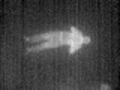

In [429]:
# ts = datetime.datetime(2024, 5, 15, 14, 40, 4, 131943, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))
# ts = datetime.datetime(2024, 5, 15, 14, 40, 9, 131893, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))
# ts = datetime.datetime(2024, 5, 15, 14, 40, 16, 965148, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))
# ts = datetime.datetime(2024, 5, 15, 14, 40, 12, 498526, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))
# ci = camera_image_for_timestamp(frame_sources[ts]['camera_time'])
ci
# mat_line = mframe.loc[mframe['Timestamp'] == ts]
# mat_line = mat_line.drop(['Timestamp', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis='columns')
# mat_line

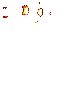

In [430]:
# ts = datetime.datetime(2024, 5, 15, 14, 40, 4, 131943, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))
# mi = mat_image_for_timestamp(frame_sources[ts]['mat_time'])
mi
# mat_line = mframe.loc[mframe['Timestamp'] == ts]
# mat_line = mat_line.drop(['Timestamp', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis='columns')
# mat_line

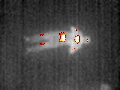

In [431]:
# ci.alpha_composite(mi, dest=(37, 27))
ci

In [36]:
def vidwrite(fn, timestamps, framerate=8, vcodec='libx264'):
    width, height = int(camera_image_width * camera_image_rescale), int(camera_image_height * camera_image_rescale)

    process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgba', s=f'{width}x{height}')
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for t in sorted(timestamps):
        ci = camera_image_for_timestamp(frame_sources[t]['camera_time'])
        mi = mat_image_for_timestamp(frame_sources[t]['mat_time'])
        ci.alpha_composite(mi, dest=(37, 27))
        process.stdin.write(ci.tobytes())
    process.stdin.close()
    process.wait()

In [37]:
vidwrite(f'{outfile_name}.mp4', frame_sources)

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-7)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libope

In [946]:
# def vidwrite(fn, images, framerate=8, vcodec='libx264'):
#     if not isinstance(images, np.ndarray):
#         images = np.asarray(images)
#     n,height,width,channels = images.shape
#     process = (
#         ffmpeg
#             .input('pipe:', format='rawvideo', pix_fmt='rgb24', s=f'{width}x{height}')
#             .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
#             .overwrite_output()
#             .run_async(pipe_stdin=True)
#     )
#     for frame in images:
#         process.stdin.write(
#             frame
#                 .astype(np.uint8)
#                 .tobytes()
#         )
#     process.stdin.close()
#     process.wait()

In [330]:
arr = (mat_line.to_numpy().astype(np.float64) / 104).reshape(mat_image_height, mat_image_width)
arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [968]:
mat_frames = mframe.drop(['Timestamp', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis='columns')
mat_frames = (mat_frames.to_numpy().astype(np.float64) / 104).reshape(-1, 64, 27)
mat_frames

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [969]:
((cm.hot(mat_frames[0]) * 255)[... , :-1]
     .astype(np.uint8)
     # .tobytes()
)

array([[[10,  0,  0],
        [10,  0,  0],
        [10,  0,  0],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]],

       [[10,  0,  0],
        [10,  0,  0],
        [10,  0,  0],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]],

       [[10,  0,  0],
        [10,  0,  0],
        [10,  0,  0],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]],

       ...,

       [[10,  0,  0],
        [10,  0,  0],
        [10,  0,  0],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]],

       [[10,  0,  0],
        [10,  0,  0],
        [10,  0,  0],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]],

       [[10,  0,  0],
        [10,  0,  0],
        [10,  0,  0],
        ...,
        [10,  0,  0],
        [10,  0,  0],
        [10,  0,  0]]], dtype=uint8)

In [970]:
mat_frames.shape

(1501, 64, 27)

In [971]:
for frame in mat_frames:
    print(len((cm.hot(frame) * 255)[... , :-1]
            .astype(np.uint8)
            .tobytes()
    ))

5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184
5184


In [972]:
mat_frames[0].shape

(64, 27)

In [973]:
b = np.hstack((mat_frames[0], np.zeros((64, 1), dtype=mat_frames.dtype)))
b.shape

(64, 28)

In [974]:
vidwrite_camera(f'{outfile_name}.mp4', camera_frames)

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-7)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libope

In [975]:
vidwrite_mat(f'{outfile_name}_mat.mp4', mat_frames)

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-7)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716144998863/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libope

In [976]:
camera_frames.dtype

dtype('float64')

In [977]:
mat_frames.dtype

dtype('float64')

In [978]:
Image.fromarray((camera_frames[camera_frame_number] * 255).astype(np.uint8)).save(f'{outfile_name}_camera.png')

In [979]:
Image.fromarray((mat_frames[mat_frame_number] * 255).astype(np.uint8)).save(f'{outfile_name}_mat.png')